In [2]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
epochs = 100
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23
print(seed)

data_dir = r"C:\RESEARCH\ck+dataset"

23


In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split=testsplit,
        preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


C:\RESEARCH\ck+dataset\anger\S502_001_00000016.png


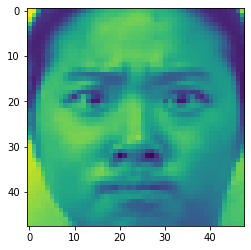

In [5]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

In [6]:
checkpoint = ModelCheckpoint('model_optimal.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

In [7]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


29084464/29084464 [==============================] - 12s 0us/step


In [8]:
model_history = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=val_generator, 
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[checkpoint])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 2.7241 - accuracy: 0.4721
Epoch 1: val_accuracy improved from -inf to 0.25389, saving model to model_optimal.h5
17/17 [==============================] - 161s 6s/step - loss: 2.7241 - accuracy: 0.4721 - val_loss: 6.5282 - val_accuracy: 0.2539
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 1.9882 - accuracy: 0.7462
Epoch 2: val_accuracy did not improve from 0.25389
17/17 [==============================] - 90s 5s/step - loss: 1.9882 - accuracy: 0.7462 - val_loss: 10.7774 - val_accuracy: 0.2539
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 1.5894 - accuracy: 0.8718
Epoch 3: val_accuracy did not improve from 0.25389
17/17 [==============================] - 91s 5s/step - loss: 1.5894 - accuracy: 0.8718 - val_loss: 4.7265 - val_accuracy: 0.2539
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 1.3411 - accuracy: 0.9353
Epoch 4: val_accuracy did not improve from 

In [9]:
history = pd.DataFrame(model_history.history)
history.to_csv('DenseNet121.csv', index=False)
history

,loss,accuracy,val_loss,val_accuracy
0,2.724057,0.472081,6.528241,0.253886
1,1.988244,0.746193,10.777370,0.253886
2,1.589381,0.871827,4.726479,0.253886
3,1.341113,0.935279,3.095082,0.212435
4,1.181379,0.963198,2.972265,0.181347
...,...,...,...,...
95,0.252672,0.983503,2.309543,0.730570
96,0.252570,0.977157,1.011963,0.880829
97,0.304388,0.972081,0.416282,0.937824
98,0.302375,0.972081,3.465080,0.533679


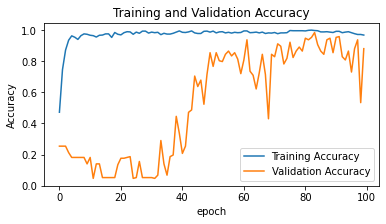

In [10]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

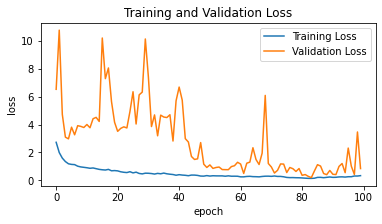

In [11]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [13]:
from keras.models import load_model

model = load_model("model_optimal.h5")

In [14]:
predictions = model.predict_generator(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

Classification Report
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.89      1.00      0.94        16
    surprise       1.00      0.96      0.98        49

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.99      0.98      0.98       193



In [15]:
#confusion matrix
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

array([[27,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  0,  0],
       [ 0,  0,  0, 14,  1,  0,  0],
       [ 0,  0,  0,  0, 41,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  0,  0,  0,  3, 46]], dtype=int64)

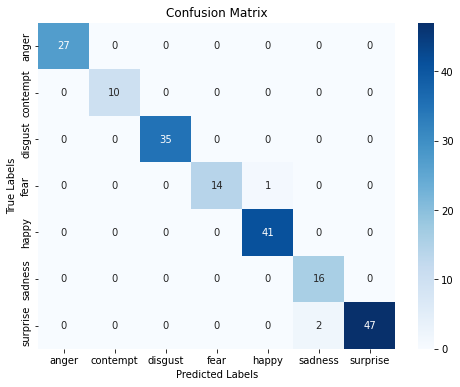

Classification Report
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.89      1.00      0.94        16
    surprise       1.00      0.96      0.98        49

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.99      0.98      0.98       193



In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_true and y_pred are your true and predicted labels
y_true = val_generator.classes
y_pred = np.argmax(model.predict_generator(val_generator), axis=1)
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display classification report
print('Classification Report')
cr = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys())
print(cr)


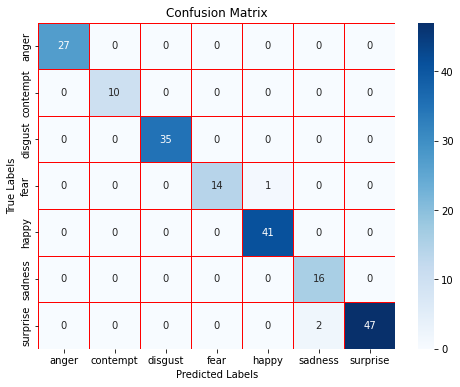

Classification Report
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.89      1.00      0.94        16
    surprise       1.00      0.96      0.98        49

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.99      0.98      0.98       193



In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_true and y_pred are your true and predicted labels
y_true = val_generator.classes
y_pred = np.argmax(model.predict_generator(val_generator), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names from the generator
target_names = list(val_generator.class_indices.keys())

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,
    linewidths=0.5,
    linecolor="red",
    fmt=".0f",
    xticklabels=target_names,
    yticklabels=target_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png', transparent=False, dpi=500)
plt.show()

# Display classification report
print('Classification Report')
cr = classification_report(y_true, y_pred, target_names=target_names)
print(cr)


In [23]:
model.evaluate(val_generator , verbose = 1)

5/5 [==============================] - 8s 875ms/step - loss: 0.1922 - accuracy: 0.9896


[0.19222573935985565, 0.9896373152732849]

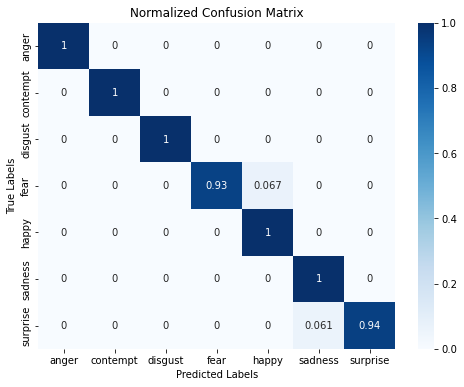

Classification Report
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.84      1.00      0.91        16
    surprise       1.00      0.94      0.97        49

    accuracy                           0.98       193
   macro avg       0.97      0.98      0.98       193
weighted avg       0.98      0.98      0.98       193



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming y_true and y_pred are your true and predicted labels
y_true = val_generator.classes
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display classification report
print('Classification Report')
cr = classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys())
print(cr)


In [29]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(val_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

5/5 [==============================] - 5s 897ms/step - loss: 0.2174 - accuracy: 0.9845
final train accuracy = 100.00 , validation accuracy = 98.45


In [32]:
from sklearn.metrics import classification_report
import re

# Assuming you have the classification report stored in the variable 'cr'
classification_report_str = '''
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.89      1.00      0.94        16
    surprise       1.00      0.96      0.98        49

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.99      0.98      0.98       193
'''

# Parse the classification report using regular expressions
class_metrics = re.findall(r'\b\w+\b\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+', classification_report_str)

# Initialize dictionaries to store metrics
precision_dict = {}
recall_dict = {}
f1_score_dict = {}

# Loop through class metrics and extract values
for line in class_metrics:
    tokens = line.split()
    if len(tokens) == 5:
        class_name = tokens[0]
        precision = float(tokens[1]) * 100  # Convert precision to percentage
        recall = float(tokens[2]) * 100  # Convert recall to percentage
        f1_score = float(tokens[3]) * 100  # Convert F1-score to percentage

        # Store values in dictionaries
        precision_dict[class_name] = precision
        recall_dict[class_name] = recall
        f1_score_dict[class_name] = f1_score

# Extract accuracy from the last line of the classification report
accuracy = float(re.search(r'accuracy\s+\d+\.\d+', classification_report_str).group().split()[-1]) * 100

# Print or use the values as needed
print(f"Accuracy: {accuracy:.2f}%")
print("Precision:")
for class_name, precision in precision_dict.items():
    print(f"{class_name}: {precision:.2f}%")
print("Recall:")
for class_name, recall in recall_dict.items():
    print(f"{class_name}: {recall:.2f}%")
print("F1-Score:")
for class_name, f1_score in f1_score_dict.items():
    print(f"{class_name}: {f1_score:.2f}%")




Accuracy: 98.00%
Precision:
anger: 100.00%
contempt: 100.00%
disgust: 100.00%
fear: 100.00%
happy: 98.00%
sadness: 89.00%
surprise: 100.00%
avg: 99.00%
Recall:
anger: 100.00%
contempt: 100.00%
disgust: 100.00%
fear: 93.00%
happy: 100.00%
sadness: 100.00%
surprise: 96.00%
avg: 98.00%
F1-Score:
anger: 100.00%
contempt: 100.00%
disgust: 100.00%
fear: 97.00%
happy: 99.00%
sadness: 94.00%
surprise: 98.00%
avg: 98.00%


In [33]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [34]:
from sklearn.metrics import classification_report
import re
from tabulate import tabulate

# Assuming you have the classification report stored in the variable 'cr'
classification_report_str = '''
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.93      0.97        15
       happy       0.98      1.00      0.99        41
     sadness       0.89      1.00      0.94        16
    surprise       1.00      0.96      0.98        49

    accuracy                           0.98       193
   macro avg       0.98      0.98      0.98       193
weighted avg       0.99      0.98      0.98       193
'''

# Parse the classification report using regular expressions
class_metrics = re.findall(r'\b\w+\b\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+', classification_report_str)

# Initialize lists to store rows of the table
table_data = [["Class", "Precision (%)", "Recall (%)", "F1-Score (%)"]]

# Loop through class metrics and extract values
for line in class_metrics:
    tokens = line.split()
    if len(tokens) == 5:
        class_name = tokens[0]
        precision = float(tokens[1]) * 100  # Convert precision to percentage
        recall = float(tokens[2]) * 100  # Convert recall to percentage
        f1_score = float(tokens[3]) * 100  # Convert F1-score to percentage

        # Append values to the table data
        table_data.append([class_name, precision, recall, f1_score])

# Extract accuracy from the last line of the classification report
accuracy = float(re.search(r'accuracy\s+\d+\.\d+', classification_report_str).group().split()[-1]) * 100

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))
print(f"\nAccuracy: {accuracy:.2f}%")


╒══════════╤═════════════════╤══════════════╤════════════════╕
│ Class    │   Precision (%) │   Recall (%) │   F1-Score (%) │
╞══════════╪═════════════════╪══════════════╪════════════════╡
│ anger    │             100 │          100 │            100 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ contempt │             100 │          100 │            100 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ disgust  │             100 │          100 │            100 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ fear     │             100 │           93 │             97 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ happy    │              98 │          100 │             99 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ sadness  │              89 │          100 │             94 │
├──────────┼─────────────────┼──────────────┼────────────────┤
│ surprise │             100 │           96 │          